In [14]:
# load data points.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib 

# for example dataset 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# for plotting 
import matplotlib.pyplot as plt 
import sys, os 
from pathlib import Path

print('Packages imported')

Packages imported


Data exists
Converted data to tensor sucessfully.
Data shape torch.Size([272, 2])


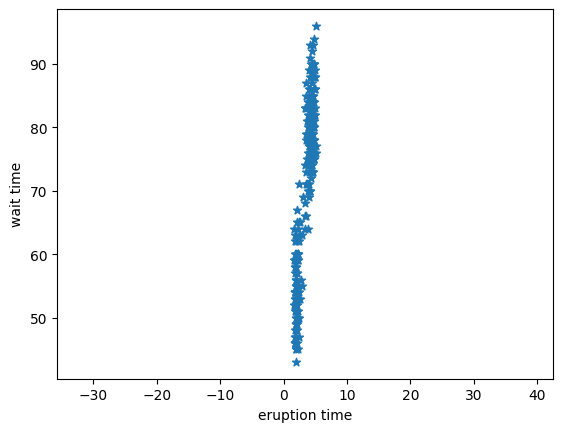

In [3]:
""" 
Run this script to load Old faithful dataset: Eruption display of old faithful  https://www.youtube.com/watch?v=wE8NDuzt8eg
"""

old_faithful_url = 'https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv'
main_path = Path(os.getcwd())

def verify(path) -> bool:
    if os.path.isfile(path):
        print('Data exists')
        return True 
    else:
        print("Attempting to download ... ")
        try:
            import requests
            response = requests.get(old_faithful_url)
            with open(path, 'wb') as file:
                file.write(response.content)
            print('Downlaoding completed')
            return True
        except Exception as e:
            print(e)
            return False
        
def read_old_faithful() -> torch.Tensor: 
    path = main_path.joinpath('ML', 'old_faithful.tsv')
    assert verify(path), 'Something went wrong while downloading! Please download data manually as save as \'old_faithful\' from {URL}.'
    data = []
    with open(path, 'r', newline='') as f:
        next(f)
        for line in f.readlines():
            sample = line.split('\t')
            data += [[float(sample[0]), float(sample[1])]]
    print('Converted data to tensor sucessfully.')
    return torch.as_tensor(data)

def visualize_old_faithful(data):
    plt.scatter(data[:, 0], data[:, 1], marker='*')
    plt.axis('equal')
    plt.ylabel('wait time')
    plt.xlabel('eruption time')
    plt.show()


# run reading
old_faithful = read_old_faithful()
print('Data shape', old_faithful.shape)

visualize_old_faithful(old_faithful)


In [4]:
from typing import Callable
""" 
MNIST samples of handwritten digits
"""
dataset_path = main_path.joinpath('mnist')
batch_size = 100 

def get_transforms(with_normalize=False) -> Callable:
    if not with_normalize:
        return transforms.Compose([
            transforms.ToTensor()])
    else:
       return transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))]) 

mnist_trans = get_transforms(True)

mnist_train_dataset = MNIST(dataset_path, transform=mnist_trans, train=True, download=True)
mnist_test_dataset = MNIST(dataset_path, transform=mnist_trans, train=False, download=True)

def visualize_mnist():
    pass 

print('Mnist dataset is downloaded.')


Mnist dataset is downloaded.


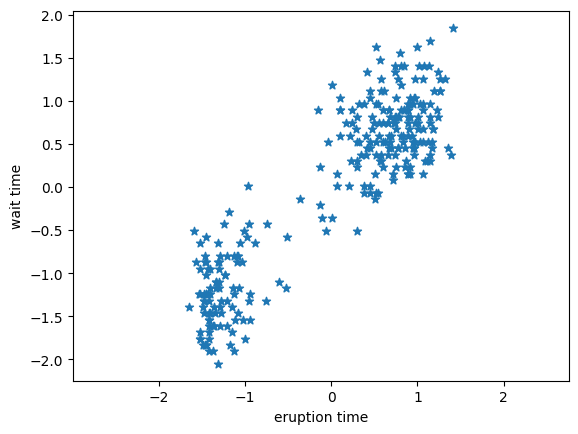

In [5]:
# typical normalization algorithms.

class Normalizer:
    @staticmethod
    def normalize(data):
        centered = data - torch.mean(data, dim=0)
        scaled =  torch.stack([(centered[:, i] / centered[:,i].std()) for i in range(data.shape[1])], dim=1)
        return scaled
    
    @staticmethod
    def whitten(data):
        # eliminating the correlation of the data 
        data = data - torch.mean(data, dim=0)
        cov = Normalizer.cov_mat(data)
        # PCA based whitening
        U, S, V = torch.svd(cov)
        S = torch.diag(S)
        S[0,0], S[1,1]= S[0,0]**-0.5, S[1,1]**-0.5
        whitened = torch.mm(torch.mm(U, S).t(), data.t()).t()
        # almost no correlation and zero variance
        return whitened
    
    @staticmethod
    def cov(data):
        mean = torch.mean(data, dim=0)
        cov = torch.mm((data-mean).t(), (data-mean)) / data.shape[0]
        return cov
    
## effects of normalization 
old_faithful_norm = Normalizer.normalize(old_faithful)
visualize_old_faithful(old_faithful_norm)

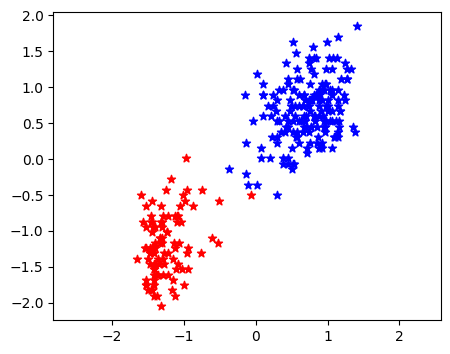

In [ ]:
""" 
Example of unsupervised learning
"""

def visualize_labelled_data(data, num_class, label):
    from itertools import product as p 

    mark = ['*', '^']
    color = ['r', 'b', 'k', 'g', 'c']
    cor = list(p(mark, color))

    _, ax = plt.subplots(figsize=(5, 4))
    
    for j in range(num_class):
        m_val, c_val = cor[j][0], cor[j][1]
        ind = label.eq(j)
        ax.scatter(data[ind,0], data[ind,1], marker=m_val, c=c_val)
    ax.set_aspect('equal', adjustable='datalim')
    return ax
    


# clustering 
def clustering(data, cluster_size=2, metric: Callable = lambda x, y: torch.norm(x - y, dim=1), itter=1000):
    
    # initalization 
    index = torch.randint(0, len(data)-1, (cluster_size,))
    means = data[index, :]
    dist = torch.zeros(len(data), cluster_size)
    label = torch.zeros(len(data))

    for _ in range(itter):
        # distance -> hard classification; we can try to control the shape of cluster size via matric
        for j in range(cluster_size):
            dist[:, j] = metric(means[j], data)

        # compute mean
        mins = torch.argmin(dist, dim=1)
        for m in range(cluster_size):
            pred = mins.eq(m)
            means[m, :] = torch.mean(data[pred, :], dim=0)
    label = mins
    return means, label, dist


""" 
uncomment the code below to play around metrics and cluster shapes.
""" 

# anchor_point = old_faithful_norm[torch.randint(0, len(old_faithful_norm), (1,)), :]
# cosine = lambda x, y: 1. - F.cosine_similarity(x -anchor_point, y -anchor_point, dim=1)

means, plabel, dist  = clustering(old_faithful_norm, 2)
ax = visualize_labelled_data(old_faithful_norm, 2, plabel)
plt.show()



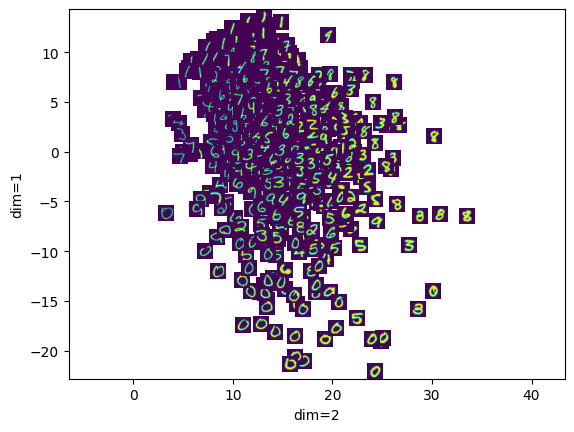

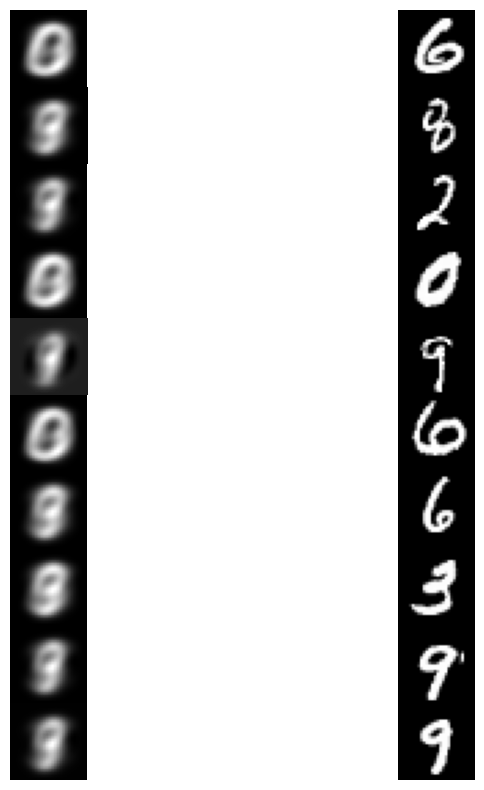

In [7]:
# another unsueprvised learning example (principla component analysis)
def pca(data, dim=2): 
    # two kinds of interperation --> maximization of variation, mimization of projection error
    # consider the equivalent estimation of PCA -- using neural nets
    cov = (data - torch.mean(data, dim=0))
    cov = (torch.mm(data.t(), data) / data.shape[0])
    U, S, V = torch.svd(cov)
    return U[:,:dim], torch.diag(S[:dim]), torch.mm(U[:,:dim].t(), data.t()).t()

def reconstruction(compressed, pcs):
    return torch.mm(compressed, pcs.T)


def decouple_data(train_data):
    data, label = [], [] 
    for d in train_data:
        data.append(d[0])
        label_es = torch.zeros(10)
        label_es[d[1]] = 1.0
        label.append(label_es)

    return torch.stack(data, dim=0), torch.stack(label, 0)


def compare_reconstruction(reconstructed, original):
    index = torch.randint(0, len(reconstructed)-1, (10,))
    rec_samples = reconstructed[index, :].reshape(-1, *original.shape[1:])
    ori_samples = original[index, :]

    rows = len(index)
    cols = 2 
    _, axes = plt.subplots(rows, cols, figsize=(10, 10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(rows):
        for j in range(cols):
            if j == 0:
                im = rec_samples 
            else:
                im = ori_samples
            ax = axes[i,j]
            ax.imshow(im[i, 0], cmap='gray')
            ax.axis('off')
    plt.show()

def visualize_mnist(data, imgs):
    _, ax = plt.subplots()
    step = 100
    ext_val = 0.8
    for i in range(0, len(data), step):
        ax.imshow(imgs[i, 0], extent=[data[i, 0]-ext_val, data[i, 0]+ext_val, data[i, 1]-ext_val, data[i, 1]+ext_val], zorder=2)  # Adjust extents for image size
        plt.scatter(data[i, 0], data[i, 1], marker='*')
    plt.axis('equal')
    plt.ylabel('dim=1')
    plt.xlabel('dim=2')
    plt.show()

mnist_data, mnist_label = decouple_data(mnist_train_dataset)
d = mnist_data.flatten(start_dim=1)
pcs, scale, projection = pca(mnist_data.flatten(start_dim=1))

reconstruction = reconstruction(projection, pcs)

# visualization.
visualize_mnist(projection, mnist_data)
compare_reconstruction(reconstruction, mnist_data)


torch.Size([272, 2])


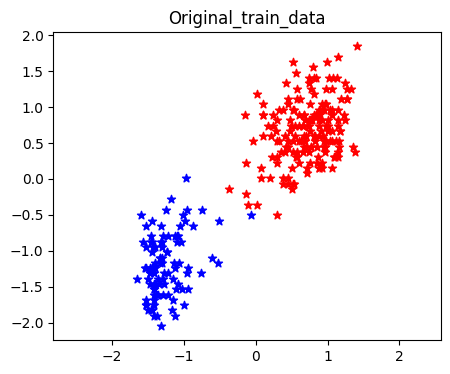

tensor([[ 0.3402, -0.3402],
        [ 0.1273, -0.1273]])


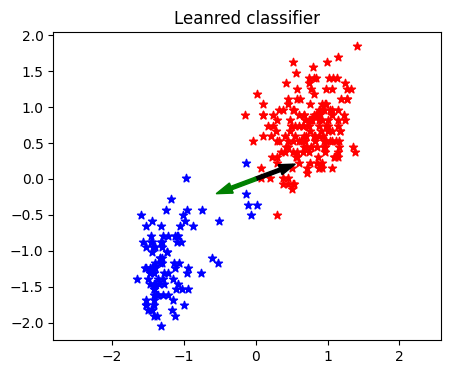

In [ ]:
""" 
Supervised learning example 
"""

class LinearClassifier:
    def __init__(self, weight: torch.Tensor| None =None, thresh: Callable = nn.Sigmoid(), features: Callable | None = None):
        self._weight = weight
        self._thresh = thresh
        self._features = features

    def train(self, train_data, label):
        data_f = train_data.flatten(start_dim=1)
        data_f = self._features(data_f) if self._features is not None else data_f

        # NOTE: different ways of solving linear regression
        #self._weight = torch.linalg.lstsq(data_f, label).solution   # new pytorch solution.
        self._weight = torch.mm(torch.linalg.pinv(data_f), label)

    def predict(self, data: torch.Tensor):
        # multi-class prediction
        data_sample = self._features(data) if self._features is not None else data 
        return self._thresh(torch.mm(data_sample, self._weight))


model = LinearClassifier(thresh=lambda x: torch.argmax(x, dim=1))

expand = F.one_hot(plabel, num_classes=2).float()
print(expand.shape)
model.train(old_faithful_norm, expand)


ax = visualize_labelled_data(old_faithful_norm, 2, plabel)
ax.set_title('Original_train_data')
plt.show() 

estimate = model.predict(old_faithful_norm)
ax2 = visualize_labelled_data(old_faithful_norm, 2, estimate)


ax2.arrow(0, 0, model._weight[0,0], model._weight[1, 0], width=0.05,color='k')
ax2.arrow(0, 0, model._weight[0,1], model._weight[1, 1], width=0.05,color='g') 
ax2.set_title('Leanred classifier')
plt.show()


In [31]:
""" 
itterative optimization for solving linear regression (pre-cursor to neural networks)
""" 

class LinearClassificatIOnOpt(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassificatIOnOpt, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        out = self.linear(x)
        return out 
    

def eval(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')


def train(train_loader, model, cost, optimizer, epoch=100):
    # training model iteratively.
    for e in range(epoch):
        model.train()
        for datum, label in train_loader:
            optimizer.zero_grad()
            estimate = model(datum)
            loss = cost(estimate, label)

            loss.backward()
            optimizer.step()

        eval(model, train_loader)
        print(f'Epoch [{e+1}/{epoch}], Loss: {loss.item():.4f}')



# setting up model 
input_size = 28*28
output = 10 

model = LinearClassificatIOnOpt(input_size=input_size, num_classes=output)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
bathc_size = 100
epoch = 10
kwargs = {'num_workers': 1, 'pin_memory': True}


train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
train(train_loader, model, loss, optimizer, epoch=epoch)


            



Accuracy of the model on the 60000 test images: 89.54%
Epoch [1/10], Loss: 0.3548
Accuracy of the model on the 60000 test images: 90.42%
Epoch [2/10], Loss: 0.2578
Accuracy of the model on the 60000 test images: 91.05%
Epoch [3/10], Loss: 0.3126
Accuracy of the model on the 60000 test images: 91.31%
Epoch [4/10], Loss: 0.4275
Accuracy of the model on the 60000 test images: 91.65%
Epoch [5/10], Loss: 0.3966
Accuracy of the model on the 60000 test images: 91.69%
Epoch [6/10], Loss: 0.3472
Accuracy of the model on the 60000 test images: 91.86%
Epoch [7/10], Loss: 0.3469
Accuracy of the model on the 60000 test images: 92.01%
Epoch [8/10], Loss: 0.3048
Accuracy of the model on the 60000 test images: 92.03%
Epoch [9/10], Loss: 0.5243
Accuracy of the model on the 60000 test images: 92.18%
Epoch [10/10], Loss: 0.3173
